In [6]:
import numpy as np
import json
import matplotlib.pyplot as plt

import os


%load_ext autoreload
%autoreload 2

"""values that you need to change"""
run_path = "/home/tianyu/TwoHopIC"




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


input data: 
<s> context(A->B, D->E, E->F ..... B->C, ...), A, C, (4 twohops in total)
(no A->C, )
train TF to predict the last token

layer 0: A->B_1, B_2->C, A do nothing
layer 1: ____, B_1->C, so C knows that its twohop starting node is A., A do thing -> 300 disappear
layer 2: C->A, predict C at the end.

<!-- real case: -->
layer 0: A->B_1, B_2->C, A do nothing -> 800
layer 1: ______, ______, B_1 -> A -> 850
layer 2: C->A, predict C at the end. -> 900



In [7]:
with open(os.path.join(run_path, 'dynamics/twoProbSumDict.json'), "rb") as f:
    twoProbSumDict = json.load(f)
with open(os.path.join(run_path, "dynamics/oneProbSumDict.json"), "rb") as f:
    oneProbSumDict = json.load(f)
with open(os.path.join(run_path, "dynamics/contextSumDict.json"), "rb") as f:
    contextSumDict = json.load(f)
with open(os.path.join(run_path, "dynamics/endSumDict.json"), "rb") as f:
    endSumDict = json.load(f)
with open(os.path.join(run_path, "dynamics/attnSummaryStep_serializable.json"), "rb") as f:
    attnSummaryStep_serializable = json.load(f)
with open(os.path.join(run_path, "dynamics/difLogitsSummaryStep.json"), "rb") as f:
    difLogitsSummaryStep = json.load(f)

In [8]:
import copy
from collections import defaultdict
def merge_nested_dicts(*dicts):
    """
    Merge multiple nested dictionaries, combining leaf values into lists.
    """
    def merge(d1, d2):
        for key, value in d2.items():
            if key in d1:
                if isinstance(d1[key], dict) and isinstance(value, dict):
                    # Recursively merge nested dictionaries
                    merge(d1[key], value)
                else:
                    # Combine non-dict values into a list
                    if not isinstance(d1[key], list):
                        d1[key] = [d1[key]]  # Convert to list if not already
                    d1[key].append(value)
            else:
                # Add new key-value pair
                d1[key] = value
        return d1

    # Start with an empty dictionary and merge all inputs
    result = {}
    for d in dicts:
        merge(result, d)
    return result

In [9]:
steps = [int(step) for step in twoProbSumDict.keys()]
twoProbSumArray = merge_nested_dicts(*twoProbSumDict.values())
oneProbSumArray = merge_nested_dicts(*oneProbSumDict.values())
attnSummaryStep_serializableArray = merge_nested_dicts(*attnSummaryStep_serializable.values())
difLogitsSummaryStepArray = merge_nested_dicts(*difLogitsSummaryStep.values())
contextSumArray = list(contextSumDict.values())
endSumArray = list(endSumDict.values())

In [10]:
def read_nested_dict(d):
    for k, v in d.items():
        if isinstance(v, dict):
            for name, value in read_nested_dict(v):
                yield [k]+name, value
        else:
            yield [k], v

target_start
target_mid
target_end
noise_start
noise_mid
noise_end


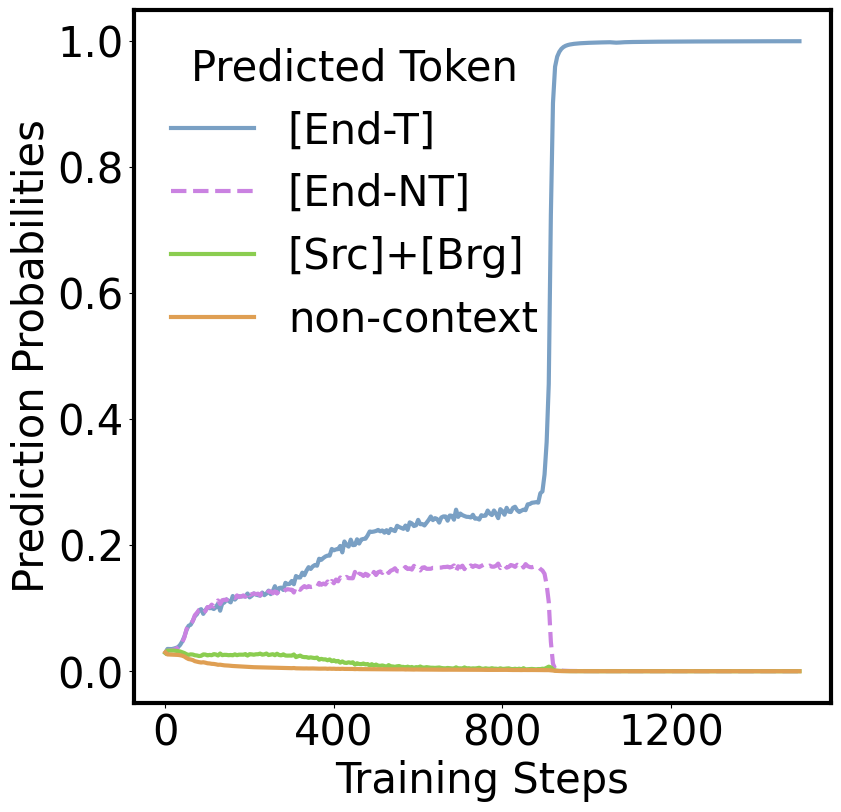

In [23]:
stepRange = 302
fontsize = 30
linesize = 3
# import scienceplots
# plt.style.use('science')
fig, ax = plt.subplots(figsize=(9, 9))
_, v = next(read_nested_dict(twoProbSumArray))
probs = {'[End-T]': np.zeros_like(v), '[End-NT]':np.zeros_like(v), '[Src]+[Brg]':np.zeros_like(v), 'non-context':np.zeros_like(v)}
group_to = {'target_end':'[End-T]', 'noise_end': '[End-NT]', 'target_start':'[Src]+[Brg]', 'target_mid':'[Src]+[Brg]', 'noise_start':'[Src]+[Brg]', 'noise_mid':'[Src]+[Brg]'}

total = np.zeros_like(v)
for k, v in read_nested_dict(twoProbSumArray):
    print('_'.join(k))
    group = group_to['_'.join(k)]
    probs[group] += np.array(v)
    total += np.array(v)
probs['non-context'] = 1 - total
probs['[End-NT]'] /= 4
probs['[Src]+[Brg]'] /= 10
probs['non-context'] /= 19
cols = ["#7aa0c4", "#ca82e1", "#8bcd50", "#df9f53", "#64b9a1",
        "#745ea6", "#db7e76"]
for n, v in probs.items():
    if n == '[End-T]':
        color = cols[0]
        ls = '-'
    elif n == '[End-NT]':
        color = cols[1]
        ls = '--'
    elif n == '[Src]+[Brg]':
        color = cols[2]
        ls = '-'
    elif n == 'non-context':
        color = cols[3]
        ls = '-'
    ax.plot(steps[:stepRange], 
                v[:stepRange], 
                label=n,     
                linewidth=linesize, 
                color=color, 
                ls=ls)
for spine in ax.spines.values():
    spine.set_linewidth(linesize)  # Set the linewidth (e.g., 2)

plt.xticks([0, 400, 800, 1200] ,fontsize=fontsize,)
plt.yticks(fontsize=fontsize,)
plt.legend(title="Predicted Token", fontsize=fontsize, title_fontsize=fontsize, loc='upper left', frameon=False)
plt.xlabel('Training Steps', fontsize=fontsize)
plt.ylabel('Prediction Probabilities', fontsize=fontsize)

plt.savefig("loss_figures/acc_dynamics.pdf", bbox_inches='tight')
# plt.grid(alpha=0.3)
plt.show()


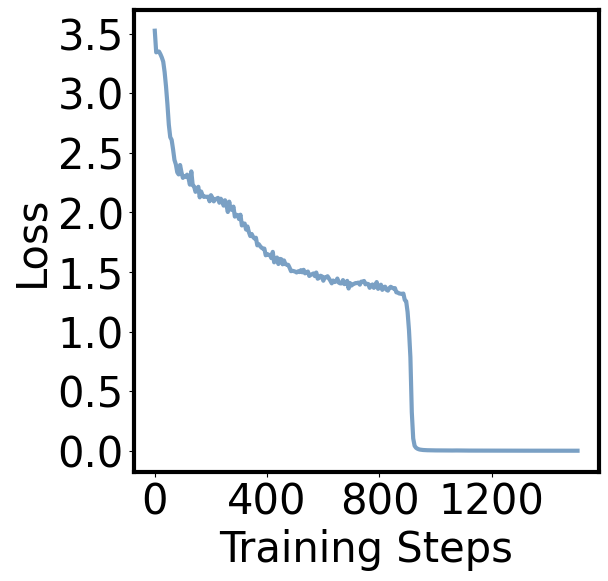

In [21]:
stepRange = 302
fontsize = 30
linesize = 3

fig, ax = plt.subplots(figsize=(6, 6))
_, v = next(read_nested_dict(twoProbSumArray))
probs = {'target-end': np.zeros_like(v)}
group_to = {'target_end':'target-end'}

# Only calculate target-end probabilities
for k, v in read_nested_dict(twoProbSumArray):
    if '_'.join(k) == 'target_end':
        probs['target-end'] = np.array(v)
        break

# Plot logarithm of target-end probability
ax.plot(steps[:stepRange], 
        -np.log(probs['target-end'][:stepRange]), 
        linewidth=linesize, 
        color="#7aa0c4",  # Using the same blue color as before
        ls='-',
        label='loss, transformer')

# Keep the same styling
for spine in ax.spines.values():
    spine.set_linewidth(linesize)

plt.xticks([0, 400, 800, 1200], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Training Steps', fontsize=fontsize)
plt.ylabel('Loss', fontsize=fontsize)  # Updated y-label

plt.savefig("neurips_figures/log_acc_dynamics.pdf", bbox_inches='tight')
plt.show()

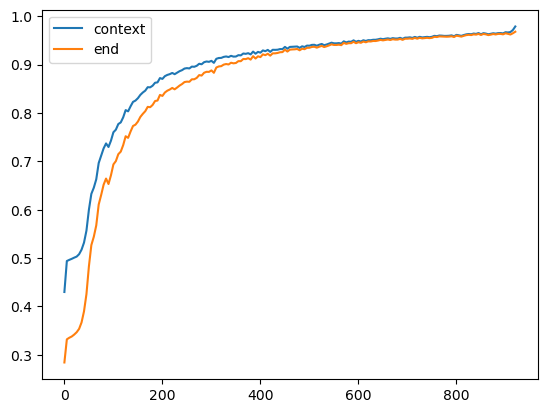

In [60]:
fig, ax = plt.subplots()
ax.plot(steps[:stepRange], contextSumArray[:stepRange], label="context")
ax.plot(steps[:stepRange], endSumArray[:stepRange], label="end")
plt.legend()
plt.show()

In [36]:
def traverse_dict(d, path=None):
    if path is None:
        path = []
    for k, v in d.items():
        if isinstance(v, dict):
            for result in traverse_dict(v, path + [k]):
                yield result
        else:
            yield path + [k], v

start, mid1, ..., mid2, end, ..., query

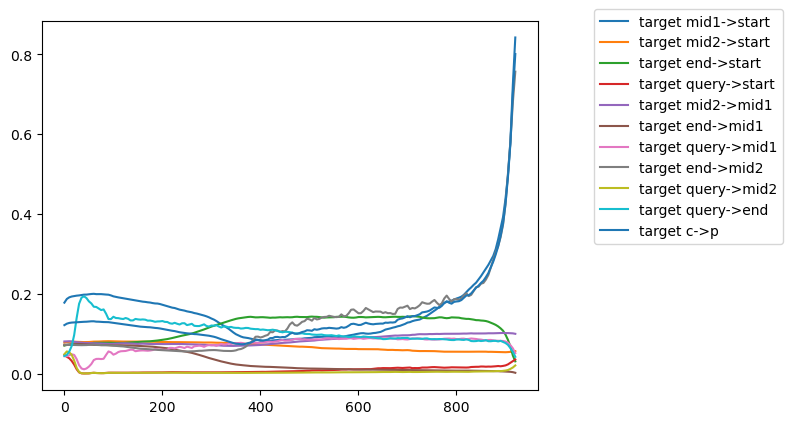

In [73]:
fig, ax = plt.subplots()
for key, value in traverse_dict(attnSummaryStep_serializableArray):
    if key[0] == '0' and key[1] == 'target':
        ax.plot(steps[:stepRange], value[:stepRange], label=f"{' '.join(key[1:])}")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

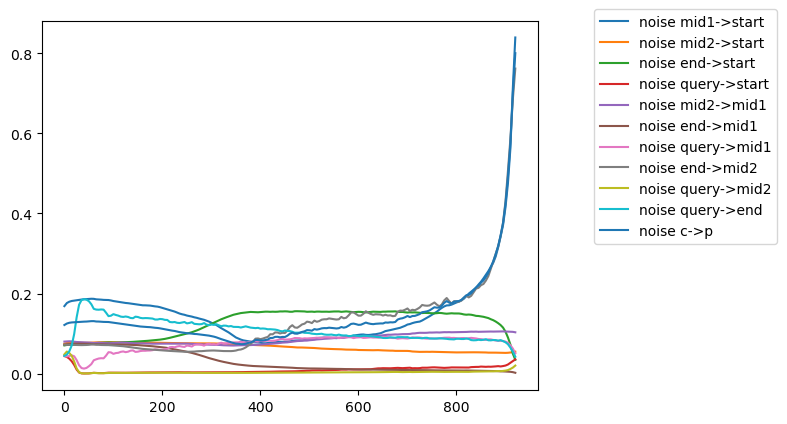

In [74]:
fig, ax = plt.subplots()
for key, value in traverse_dict(attnSummaryStep_serializableArray):
    if key[0] == '0' and key[1] == 'noise':
        ax.plot(steps[:stepRange], value[:stepRange], label=f"{' '.join(key[1:])}")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

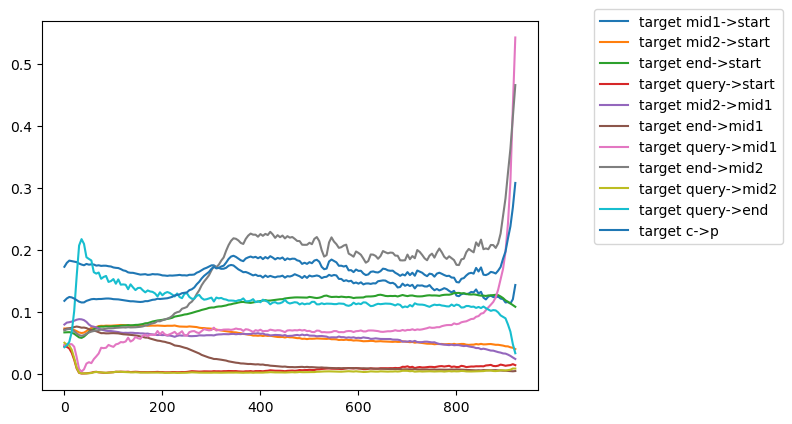

In [78]:
stepRange = 185

fig, ax = plt.subplots()
for key, value in traverse_dict(attnSummaryStep_serializableArray):
    if key[0] == '1' and key[1] == 'target':
        ax.plot(steps[:stepRange], value[:stepRange], label=f"{' '.join(key[1:])}")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

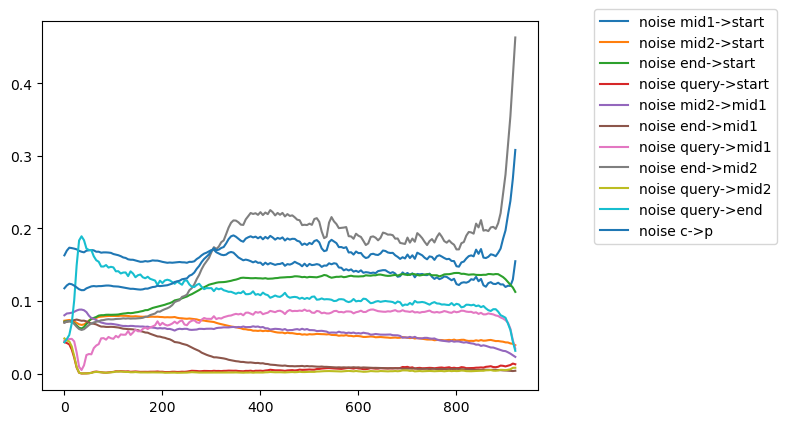

In [79]:
stepRange = 185

fig, ax = plt.subplots()
for key, value in traverse_dict(attnSummaryStep_serializableArray):
    if key[0] == '1' and key[1] == 'noise':
        ax.plot(steps[:stepRange], value[:stepRange], label=f"{' '.join(key[1:])}")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

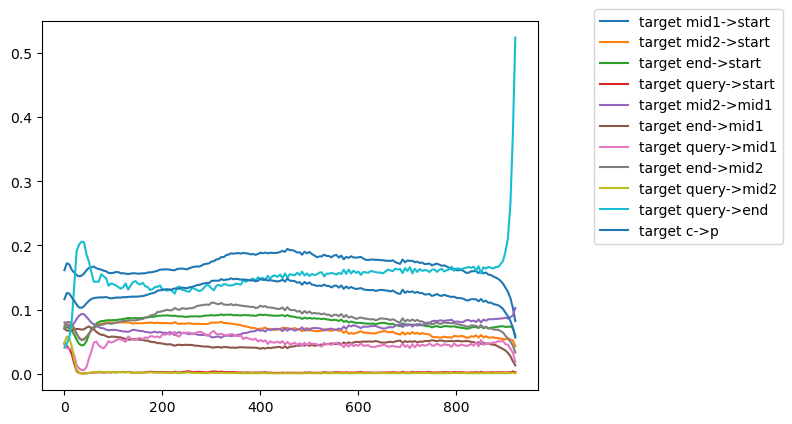

In [64]:
fig, ax = plt.subplots()
for key, value in traverse_dict(attnSummaryStep_serializableArray):
    if key[0] == '2' and key[1] == 'target':
        ax.plot(steps[:stepRange], value[:stepRange], label=f"{' '.join(key[1:])}")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()


layer 0: copy -mid, -start

explain layer 1: attn(end->mid1) is small
(end-mid) * (mid-start) = -mid^2 < 0

mid: mid-start
end: end-mid

query = mid+end = end-start
e^-start \approx e^0

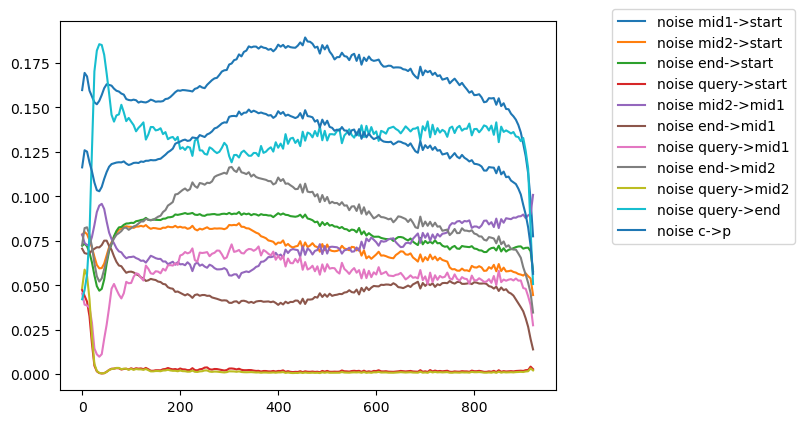

In [80]:
fig, ax = plt.subplots()
for key, value in traverse_dict(attnSummaryStep_serializableArray):
    if key[0] == '2' and key[1] == 'noise':
        ax.plot(steps[:stepRange], value[:stepRange], label=f"{' '.join(key[1:])}")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

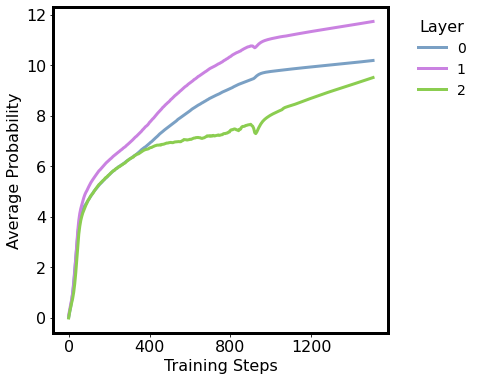

In [ ]:
difLogitsSummaryStepNpArray = {k: np.array([v1 for v1 in v.values()]) for k, v in difLogitsSummaryStepArray.items()}
# difLogitsSummaryStepNpArray['0'][1:, :].mean(axis=0)

fontsize = 16
linesize = 3
fig, ax = plt.subplots(figsize=(6, 6))
cols = ["#7aa0c4", "#ca82e1", "#8bcd50", "#df9f53", "#64b9a1", "#745ea6", "#db7e76"]

for layer_idx in range(3):
    ax.plot(steps[:stepRange], 
            difLogitsSummaryStepNpArray[str(layer_idx)][1:, :].mean(axis=0)[:stepRange], 
            label=str(layer_idx),
            linewidth=linesize,
            color=cols[layer_idx])

for spine in ax.spines.values():
    spine.set_linewidth(linesize)

plt.xticks([0, 400, 800, 1200], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(bbox_to_anchor=(1.05, 1), title="Layer", loc='upper left', fontsize=14, title_fontsize=fontsize, frameon=False)
plt.xlabel('Training Steps', fontsize=fontsize)
plt.ylabel('Average Logits Difference', fontsize=fontsize)
plt.savefig("icml_figures/difLogits_dynamics.pdf", bbox_inches='tight')

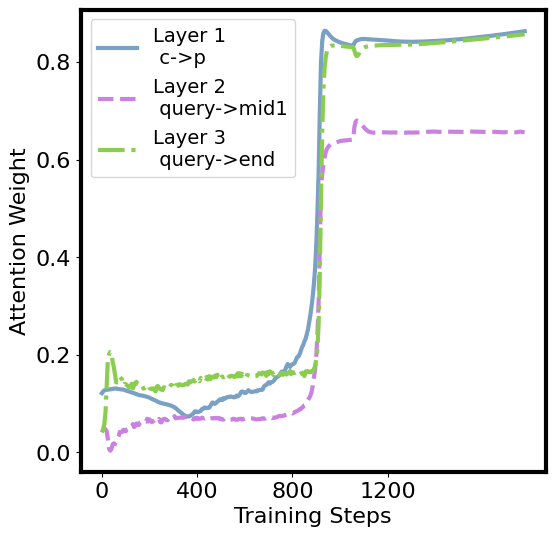

In [37]:
stepRange = 356
fontsize = 16
linesize = 3

fig, ax = plt.subplots(figsize=(6, 6))
cols = ["#7aa0c4", "#ca82e1", "#8bcd50"]  # Using the same color scheme as before

# Plot the three specific attention patterns
for key, value in traverse_dict(attnSummaryStep_serializableArray):
    if (key[0] == '0' and key[1] == 'target' and key[2] == 'c->p'):
        ax.plot(steps[:stepRange], value[:stepRange], 
                label='Layer 1\n c->p',
                linewidth=linesize,
                ls='-',
                color=cols[0])
    elif (key[0] == '1' and key[1] == 'target' and key[2] == 'query->mid1'):
        ax.plot(steps[:stepRange], value[:stepRange], 
                label='Layer 2\n query->mid1',
                linewidth=linesize,
                ls='--',
                color=cols[1])
    elif (key[0] == '2' and key[1] == 'target' and key[2] == 'query->end'):
        ax.plot(steps[:stepRange], value[:stepRange], 
                label='Layer 3\n query->end',
                linewidth=linesize,
                ls='-.',
                color=cols[2])

# Styling
for spine in ax.spines.values():
    spine.set_linewidth(linesize)

plt.xticks([0, 400, 800, 1200], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(loc='upper left', fontsize=14, title_fontsize=fontsize, frameon=True)
plt.xlabel('Training Steps', fontsize=fontsize)
plt.ylabel('Attention Weight', fontsize=fontsize)

plt.savefig("icml_figures/attention_patterns.pdf", bbox_inches='tight')
plt.show()